In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

import random
import tqdm

In [2]:
data_dir = '../data'

In [21]:
df_channel_analytics = pd.read_csv(f'{data_dir}/channel_analytics.csv')
df_channel_post_analytics = pd.read_csv(f'{data_dir}/channel_post_analytics.csv')
df_entity = pd.read_csv(f'{data_dir}/entity.csv')
df_mention = pd.read_csv(f'{data_dir}/mention.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
df_channel_post_analytics

,msg_id,channel_id,views,forwards,comments,reactions,posted
0,2647,1001957400,1360,47,NaN,38.0,2023-01-26 14:52:37
1,2648,1001957400,1223,19,NaN,33.0,2023-01-29 16:13:39
2,2649,1001957400,1053,12,NaN,19.0,2023-01-30 09:20:43
3,2650,1001957400,1293,6,NaN,25.0,2023-01-30 10:29:24
4,2651,1001957400,998,15,NaN,22.0,2023-01-31 19:19:35
...,...,...,...,...,...,...,...
30242977,1429,1780353352,1366,1,4.0,0.0,2023-03-29 14:24:32
30242978,469,1797330052,2334,86,22.0,74.0,2023-03-29 13:48:17
30242979,2501,1817036552,164,0,0.0,NaN,2023-03-29 13:44:50
30242980,3623,1857818452,20713,21,4.0,NaN,2023-03-29 14:22:28


In [25]:
df_channel_analytics['members_count'].sum()

1706362133

In [27]:
df_channel_post_analytics['posted'] = pd.to_datetime(df_channel_post_analytics['posted'])
df_channel_post_analytics

,msg_id,channel_id,views,forwards,comments,reactions,posted
0,2647,1001957400,1360,47,NaN,38.0,2023-01-26 14:52:37
1,2648,1001957400,1223,19,NaN,33.0,2023-01-29 16:13:39
2,2649,1001957400,1053,12,NaN,19.0,2023-01-30 09:20:43
3,2650,1001957400,1293,6,NaN,25.0,2023-01-30 10:29:24
4,2651,1001957400,998,15,NaN,22.0,2023-01-31 19:19:35
...,...,...,...,...,...,...,...
30242977,1429,1780353352,1366,1,4.0,0.0,2023-03-29 14:24:32
30242978,469,1797330052,2334,86,22.0,74.0,2023-03-29 13:48:17
30242979,2501,1817036552,164,0,0.0,NaN,2023-03-29 13:44:50
30242980,3623,1857818452,20713,21,4.0,NaN,2023-03-29 14:22:28


In [43]:
df_channel_post_analytics.groupby(df_channel_post_analytics.posted.dt.month)['views'].sum().mean()

58183155885.333336

In [4]:
df_entity['birthdate'] = pd.to_datetime(df_entity['birthdate'])
merged_df = pd.merge(df_channel_analytics, df_channel_post_analytics, on='channel_id', how='inner')
df_entity = df_entity.rename(columns={"id": "channel_id"})
df_mention = df_mention.rename(columns={"entity_id": "channel_id"})
merged_df = pd.merge(merged_df, df_entity, on='channel_id', how='inner')
filtered_df = merged_df.loc[
    (merged_df['members_count'] > 5000) &
    (merged_df['er'] > 10) &
    (merged_df['language_code'] =='ru') &
    (merged_df['birthdate'] < (datetime.today() - relativedelta(months=4))) &
    (merged_df['ios_ban']==False) & (merged_df['scam']==False) &
    (merged_df['fake']==False) & (merged_df['hidden']==False) & (merged_df['blocked']==False) &
    (~merged_df[['msg_id', 'channel_id']].isin(df_mention[['msg_id', 'channel_id']]).any(1))
]

In [5]:
filtered_posts_df = filtered_df[['msg_id', 'channel_id', 'posted',
             'views', 'forwards', 'comments', 'reactions']].reset_index(drop=True)

In [43]:
filtered_posts_df.to_csv(data_dir+'/filtered_posts.csv')

In [ ]:
filtered_posts_df

In [6]:
df_mention['created'] = pd.to_datetime(df_mention['created'])

df_mention=df_mention[
    (df_mention['channel_id'].isin(filtered_posts_df['channel_id'])) &
    (df_mention['mention_type'] == 'normal')].sort_values(by=['created'])

df_mention = df_mention.dropna(subset=['entity_views']).reset_index(drop=True)

In [67]:
df_mention.head()

,msg_id,channel_id,userbot_id,mentioned,link_value,link_type,counter,mention_type,entity_members_count,entity_views,sponsored_message_text,created
0,106,1237079516,5725674574,1307300150,remote_ru,public_channel,1,normal,5256.0,914.0,NaN,2021-01-30 11:49:18
1,104,1000683515,5866808282,1296537771,bossofyourboss,public_channel,1,normal,13629.0,3728.0,NaN,2021-03-27 11:47:27
2,116,1237079516,5725674574,1374049785,uptume,public_channel,1,normal,5256.0,914.0,NaN,2021-03-30 11:30:00
3,124,1237079516,5725674574,1374049785,uptume,public_channel,1,normal,5256.0,914.0,NaN,2021-05-13 11:15:00
4,273,1380021391,5974701115,1370554138,mir2051,public_channel,1,normal,19193.0,6437.0,NaN,2021-06-08 11:00:05


In [166]:
df_mention.groupby(['mentioned'])['channel_id'].count().describe()

count    75419.000000
mean        12.673981
std         75.549161
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       9562.000000
Name: channel_id, dtype: float64

In [7]:
channels = df_mention['channel_id'].unique()

# user_channels = {user_id: [] for user_id in range(100000000, 110000001)}
# channel_users = {channel_id: [] for channel_id in channels}

user_channels = {}
channel_users = {}
import time
# from itertools import ifilter


next_without_channel = 100000000

for index, row in tqdm.tqdm(df_mention.iterrows()):
    channel_id = row['channel_id']
    mentioned_id = row['mentioned']
    entity_views = int(row['entity_views'])
    # if channel_id in channel_users:
    #     users_with_channel = channel_users[channel_id]
    # else:
    #     users_with_channel = []
    users_with_channel = channel_users.get(channel_id, [])
        
        
    if len(users_with_channel) == 0:
        if next_without_channel >= 105000000:
            next_without_channel = 100000000
        # если нет, то добавляем случайным образом user_id канал
        # user_set = set(range(100000000, 110000001))
        # user_set.difference_update(user_channels.keys())
        # users_without_channels = list(user_set)
        # users_without_channels = [user_id for user_id in range(100000000, 110000001) if user_channels.get(user_id)]
        # users_without_channels = random.sample(users_without_channels, min(len(users_without_channels), entity_views))
        
        min_ = min(105000000 - next_without_channel, entity_views)
        users_without_channels = list(range(next_without_channel, next_without_channel + min_ + 1))
        next_without_channel = next_without_channel + min_ + 1
        # user_ids = range(100000000, 110000001)
        # users_without_channels = filter(lambda user_id: not user_channels.get(user_id), user_ids)
        # num_users_without_channels = sum(1 for _ in users_without_channels)
        # users_without_channels = random.sample(range(100000000, 110000001), min(num_users_without_channels, entity_views))

        for user_id in users_without_channels:
            if user_id not in user_channels:
                user_channels[user_id] = [channel_id]
            else:
                user_channels[user_id].append(channel_id)
        channel_users[channel_id] = users_without_channels
        
        users_with_channel = channel_users.get(channel_id, [])
        users_with_channel = random.sample(users_with_channel, min(len(users_with_channel), entity_views//100))
        for user_id in users_with_channel:
            user_channels[user_id].append(mentioned_id)
        if mentioned_id not in channel_users:
            channel_users[mentioned_id] = []
        channel_users[mentioned_id].extend(users_with_channel)
    else:
        users_with_channel = random.sample(users_with_channel, min(len(users_with_channel), entity_views//100))
        for user_id in users_with_channel:
            user_channels[user_id].append(mentioned_id)
        if mentioned_id not in channel_users:
            channel_users[mentioned_id] = []
        channel_users[mentioned_id].extend(users_with_channel)

957631it [07:00, 2278.37it/s]


In [8]:
result_list = []

for key, values in tqdm.tqdm(user_channels.items()):
    for value in values:
        result_list.append((key, value))

100%|██████████| 5000001/5000001 [00:58<00:00, 85298.60it/s] 


In [9]:
df_user_channel = pd.DataFrame.from_records(result_list, columns=['user_id', 'channel_id'])
df_user_channel

,user_id,channel_id
0,100000000,1237079516
1,100000000,1387770587
2,100000000,1177293183
3,100000000,1225597716
4,100000000,1291701327
...,...,...
197399614,105000000,1592918277
197399615,105000000,1260622817
197399616,105000000,1436896962
197399617,105000000,1138734339


In [10]:
# df_user_channel = (df_user_channel[df_user_channel.groupby(['user_id']).count() <= 82]).reset_index(drop=True)

In [10]:
df_user_channel.to_csv(data_dir+'/user_channel.csv', index=False)

In [28]:
import csv

w = csv.writer(open(data_dir + "/user_channels_dict.csv", "w"))

# loop over dictionary keys and values
for key, val in user_channels.items():
    w.writerow([key, val])

In [29]:
import csv

w = csv.writer(open(data_dir + "/channel_users_dict.csv", "w"))

# loop over dictionary keys and values
for key, val in channel_users.items():
    w.writerow([key, val])

In [14]:
filtered_posts_df['er'] = ((np.nan_to_num(filtered_posts_df['forwards']) + np.nan_to_num(filtered_posts_df['comments']) + np.nan_to_num(filtered_posts_df['reactions'])) \
    / (3 - sum([np.isnan(filtered_posts_df['forwards']), np.isnan(filtered_posts_df['comments']), np.isnan(filtered_posts_df['reactions'])])))\
    / filtered_posts_df['views']
filtered_posts_df['er'] = filtered_posts_df['er'].fillna(0)
filtered_posts_df

,msg_id,channel_id,posted,views,forwards,comments,reactions,er
0,96088,1001104273,2023-01-25 18:31:44,10807,1,2.0,15.0,0.000555
1,96089,1001104273,2023-01-25 19:27:44,3086,2,0.0,3.0,0.000540
2,96090,1001104273,2023-01-26 09:46:43,3186,2,1.0,6.0,0.000942
3,96091,1001104273,2023-01-26 15:10:57,9056,2,1.0,16.0,0.000699
4,96092,1001104273,2023-01-26 19:12:04,3040,1,1.0,17.0,0.002083
...,...,...,...,...,...,...,...,...
5114164,2385,1424762857,2023-03-27 21:25:43,8442,0,27.0,632.0,0.026021
5114165,2387,1424762857,2023-03-28 10:45:33,7452,2,27.0,329.0,0.016014
5114166,2390,1424762857,2023-03-28 11:52:55,7221,190,20.0,312.0,0.024096
5114167,2392,1424762857,2023-03-29 12:19:11,7800,3,23.0,380.0,0.017350


In [15]:
filtered_posts_df['er'] = filtered_posts_df['er'].apply(lambda x: x if x <= 1 else 1)

In [16]:
filtered_posts_df = filtered_posts_df[filtered_posts_df['er'] >= 0.01]

In [17]:
diff_ = list(set(filtered_posts_df['channel_id'].unique()).difference(set(channel_users.keys())))
filtered_posts_df = filtered_posts_df.loc[~(filtered_posts_df['channel_id'].isin(diff_))]

In [18]:
filtered_posts_df = filtered_posts_df.reset_index(drop=True)

In [19]:
filtered_posts_df.to_csv(data_dir+'/filtered_posts.csv')

In [20]:
filtered_posts_key_value = filtered_posts_df[['msg_id', 'channel_id']].to_dict('index')

In [6]:
df_entity = pd.read_csv(f'{data_dir}/entity.csv')
filtered_posts_df = pd.read_csv(f'{data_dir}/filtered_posts.csv', index_col='Unnamed: 0')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
filtered_posts_df

,msg_id,channel_id,posted,views,forwards,comments,reactions,er
0,96234,1001104273,2023-03-01 13:50:08,3427,14,44.0,54.0,0.010894
1,96298,1001104273,2023-03-07 18:21:14,3343,28,9.0,80.0,0.011666
2,96382,1001104273,2023-03-15 14:25:35,2754,9,4.0,83.0,0.011619
3,96389,1001104273,2023-03-15 17:33:14,2958,10,5.0,76.0,0.010255
4,96394,1001104273,2023-03-16 11:36:01,2818,11,24.0,61.0,0.011356
...,...,...,...,...,...,...,...,...
1696829,2385,1424762857,2023-03-27 21:25:43,8442,0,27.0,632.0,0.026021
1696830,2387,1424762857,2023-03-28 10:45:33,7452,2,27.0,329.0,0.016014
1696831,2390,1424762857,2023-03-28 11:52:55,7221,190,20.0,312.0,0.024096
1696832,2392,1424762857,2023-03-29 12:19:11,7800,3,23.0,380.0,0.017350


In [16]:
filtered_posts_key_value = filtered_posts_df.merge(df_entity.rename(columns={'id': 'channel_id'})[['channel_id', 'username']], on='channel_id')[['msg_id', 'channel_id', 'username']]

In [17]:
filtered_posts_key_value = filtered_posts_key_value.to_dict('index')

In [18]:
import csv

w = csv.writer(open(data_dir + "/filtered_posts_key_value.csv", "w"))

# loop over dictionary keys and values
for key, val in filtered_posts_key_value.items():
    w.writerow([key, val])

In [30]:
import csv

w = csv.writer(open(data_dir + "/filtered_posts_key_value.csv", "w"))

# loop over dictionary keys and values
for key, val in filtered_posts_key_value.items():
    w.writerow([key, val])

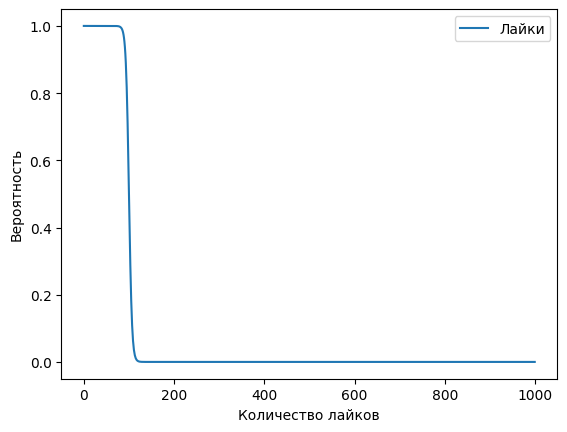

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 1000)
b = 100

z = logistic(x, a, b)
z = z/z[0]
fig, ax = plt.subplots()
ax.plot(x, z, label='Лайки')
# ax.plot(x, 1 - z, label='Неуважительные комментарии')
ax.set_xlabel('Количество лайков')
ax.set_ylabel('Вероятность')
ax.legend()
plt.show()

In [36]:
filtered_posts_df.shape

(1696834, 8)

In [36]:
for index, row in tqdm.tqdm(filtered_posts_df.iterrows()):

,msg_id,channel_id,posted,views,forwards,comments,reactions,er
122,96234,1001104273,2023-03-01 13:50:08,3427,14,44.0,54.0,0.010894
178,96298,1001104273,2023-03-07 18:21:14,3343,28,9.0,80.0,0.011666
259,96382,1001104273,2023-03-15 14:25:35,2754,9,4.0,83.0,0.011619
265,96389,1001104273,2023-03-15 17:33:14,2958,10,5.0,76.0,0.010255
270,96394,1001104273,2023-03-16 11:36:01,2818,11,24.0,61.0,0.011356
...,...,...,...,...,...,...,...,...
5114091,2385,1424762857,2023-03-27 21:25:43,8442,0,27.0,632.0,0.026021
5114092,2387,1424762857,2023-03-28 10:45:33,7452,2,27.0,329.0,0.016014
5114093,2390,1424762857,2023-03-28 11:52:55,7221,190,20.0,312.0,0.024096
5114094,2392,1424762857,2023-03-29 12:19:11,7800,3,23.0,380.0,0.017350


In [72]:
df_channel_post_analytics

,msg_id,channel_id,views,forwards,comments,reactions,posted
0,2647,1001957400,1360,47,NaN,38.0,2023-01-26 14:52:37
1,2648,1001957400,1223,19,NaN,33.0,2023-01-29 16:13:39
2,2649,1001957400,1053,12,NaN,19.0,2023-01-30 09:20:43
3,2650,1001957400,1293,6,NaN,25.0,2023-01-30 10:29:24
4,2651,1001957400,998,15,NaN,22.0,2023-01-31 19:19:35
...,...,...,...,...,...,...,...
30242977,1429,1780353352,1366,1,4.0,0.0,2023-03-29 14:24:32
30242978,469,1797330052,2334,86,22.0,74.0,2023-03-29 13:48:17
30242979,2501,1817036552,164,0,0.0,NaN,2023-03-29 13:44:50
30242980,3623,1857818452,20713,21,4.0,NaN,2023-03-29 14:22:28


In [29]:
df_channel_post_analytics['posted'] = pd.to_datetime(df_channel_post_analytics['posted'])

In [50]:
df_channel_post_analytics['views'].sum()

174549467656

In [34]:
df_entity

,channel_id,created_with,entity_type,photo_id,photo_url,first_message_read,userbot_id,name,username,access_hash,...,cheat_created,ios_ban,scam,verified,fake,hidden,blocked,language_code,birthdate,created
0,1610995496,NaN,public_channel,5.472302e+18,https://telegra.ph/file/8bfdab6f783b8dc653ee5.jpg,True,5.867965e+09,PanStandUp,panstandup,-3962254009726019372,...,NaN,False,False,False,False,False,False,be,2022-08-08 15:50:07,2023-01-26 20:20:56.994689
1,1789104687,NaN,public_channel,5.256092e+18,https://telegra.ph/file/8e59a247c7bf2fefa3623.jpg,True,5.393663e+09,Perusha,perushag,7057200524768072727,...,NaN,False,False,False,False,False,False,ru,2023-02-16 13:03:54,2023-02-18 08:30:23.964101
2,1583310759,NaN,public_channel,5.424607e+18,https://telegra.ph/file/6efc1be41c6aa362659cb.jpg,True,NaN,اربح كاش معنا 💲,rv_j9,-8534526936928294722,...,NaN,False,False,False,False,False,False,NaN,2022-01-15 16:00:44,2023-02-25 07:32:07.503696
3,1728446154,NaN,public_channel,5.336846e+18,https://telegra.ph/file/3d97461df8da04f0e875a.jpg,True,5.577781e+09,DREAM POV,povmex,1453038383022008147,...,NaN,True,False,False,False,False,False,ru,2023-01-13 15:04:51,2023-01-26 14:44:01.349971
4,1436274540,NaN,public_channel,5.382082e+18,https://telegra.ph/file/6b5a56d9dcecc1a6512b0.jpg,True,5.864209e+09,Володимир Назаренко,nazarenkovolodymyr,-4403316951522258700,...,NaN,False,False,False,False,False,False,uk,2020-01-14 12:24:58,2023-01-28 21:30:48.070326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189355,1632009520,NaN,public_channel,5.274257e+18,https://telegra.ph/file/b0e5005984d4cd19168f1.jpg,True,5.421361e+09,𝙬𝙮𝙚𝙭𝙪𝙨 ۶ music,yachiru_08,-4364115192946804913,...,NaN,False,False,False,False,False,False,ru,2022-08-22 19:32:19,2023-01-27 07:11:24.830481
189356,1587149148,NaN,public_channel,5.359536e+18,https://telegra.ph/file/38d9e8898dadf42e05e63.jpg,True,5.539454e+09,О чем говорят в Омске,omsk_region,-1104072305380144691,...,NaN,False,False,False,False,False,False,ru,2022-03-13 20:09:42,2023-01-29 01:10:46.684026
189357,1602242001,NaN,public_channel,5.195127e+18,https://telegra.ph/file/d7985f5fef85542a4197b.jpg,True,5.474815e+09,Захід Головне,zahid_golovne_ua,-2009640455254369524,...,NaN,False,False,False,False,False,False,uk,2022-08-21 14:46:27,2023-01-26 20:36:42.596110
189358,1816386868,NaN,public_channel,5.273996e+18,https://telegra.ph/file/e583488344f328553e151.jpg,True,5.565152e+09,х϶ᴧᴨ ᴏᴛ н϶ᴛᴛи | ᴊᴜʟxsɪ.♡,julxsi,4761631173184222056,...,NaN,False,False,False,False,False,False,ru,2022-11-30 06:53:41,2023-01-28 10:21:10.411307
